##### 【 ML - 생성 분류 모델 만들기 5 】

- 주____제: 2개 종류 생선 분류 모델 만들기
- 학습종류: 지도학습 -> 분류 
- 학습방법: 다양한 분류 알고리즘들 => KNN 최근접이웃알고리즘

- 데이터셋
    * 학습용 데이터셋 
        - 모델 학습에 즉, 데이터의 규칙과 패턴 찾기위해서 사용되는 데이터셋

    * 검증용 데이터셋
        - 모델 학습 중 제대로 규칙과 패턴 찾고 있는지 검사하기 위한 데이터셋
        - scikit-learn은 fit()메서드로 학습 종료되어서 사용 할 수 없음
        - 교차검증, 일부 학습 알고리즘에서는 사용 가능

    * 테스트용 데이터셋
        - 학습 완료 후 성능검사에 사용되는 데이터셋
        - 추가 학습 진행 여부 결정 기준이 됨!
        - ★절대 학습에 사용되면 안됨!!★

[1] 데이터 확인 : 피쳐와 타겟 <hr>

In [2]:
## [1-1] 모듈 로딩 및 데이터 준비
import pandas as pd 
import matplotlib.pyplot as plt
import koreanize_matplotlib 

## ML 학습알고리즘 모델
from sklearn.neighbors import KNeighborsClassifier 
## 데이터셋 관련 
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

In [3]:
## CoW 기능 활성화 : 데이터 변경시 복사 후 처리 
pd.options.mode.copy_on_write = True

In [4]:
## [1-2] 데이터 로딩 및 빙어와도미 데이터만 추출
DATA_FILE='../Data/fish.csv'

## 품종, 무게, 길이 컬럼만 추출
allDF = pd.read_csv(DATA_FILE, usecols=[0,1,2])
#display(allDF.head(3))

## Bream 도미, Smelt 빙어 행만 추출
fishDF = allDF[(allDF.Species == 'Bream') | (allDF.Species == 'Smelt')]

## 행인덱스 초기화 
fishDF.reset_index(drop=True, inplace=True)
#display(fishDF.head(3), fishDF.tail(3))
#fishDF.info()


In [5]:
## [1-3] 무게와 길이 피쳐와 품종 분류 가능 여부  
## 품종 컬럼 타입 변환 저장 
speciesSR = fishDF.Species
fishDF.Species=speciesSR.astype('category')
## 전체 데이터 타입 확인
#fishDF.info()

In [6]:
## 카테고리 접근자 cat 사용
print(f'[categories] => {fishDF.Species.cat.categories}')
print(f'[codes]      =>\n{fishDF.Species.cat.codes}')

[categories] => Index(['Bream', 'Smelt'], dtype='object')
[codes]      =>
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    1
36    1
37    1
38    1
39    1
40    1
41    1
42    1
43    1
44    1
45    1
46    1
47    1
48    1
dtype: int8


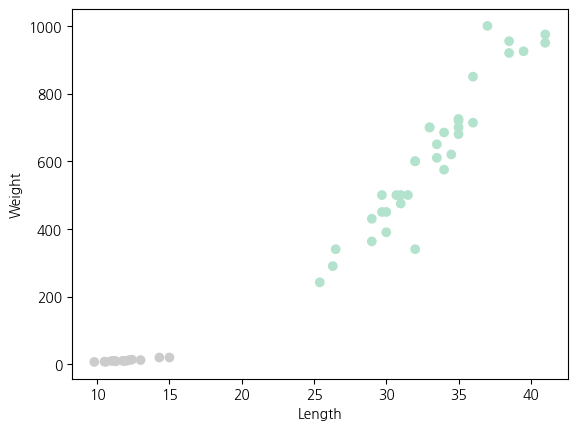

,Weight,Length
Weight,1.000000,0.960347
Length,0.960347,1.000000


In [7]:
## - 시각화 : 산점도 => 색상을 품종에따라 다르게 설정 c 매개변수
plt.scatter(fishDF.Length, fishDF.Weight, c=fishDF.Species.cat.codes , cmap='Pastel2')
plt.xlabel('Length')
plt.ylabel('Weight')
plt.show()

## - 상관계수 
fishDF.corr(numeric_only=True)


[2] 피쳐/데이터와 타겟/라벨 분리<hr>

In [8]:
## 학습용 피쳐/데이터와 타겟/라벨 분리 
## -> 피쳐/데이터 : 2D
featureDF = fishDF[fishDF.columns[1:]]

## -> 타겟/라벨 : 1D 
targetSR  = fishDF[fishDF.columns[0]]

print(f'featureDF : {featureDF.shape} / {featureDF.ndim}D')
print(f'ftargetSR : {targetSR.shape} / {targetSR.ndim}D')


featureDF : (49, 2) / 2D
ftargetSR : (49,) / 1D


[3] 학습용, 테스트용 데이터셋 분리<hr>
- 일반적 : 학습용 : 테스트용 = 8 : 2 
- 수집된 데이터에 따라서 학습용 데이터셋 비율 설정 
- scikit-learn 기본값 => 7.5 : 2.5 

In [9]:
## train_test_split(2D피쳐, 1D타겟, ....) => 반환 4개 원소 튜플
## 매개변수
## -> test_size  = 0.25
## -> train_size = 0.75
## -> random_state = None   : 전달한 데이터셋 섞어서 랜덤 추출 
## -> stratify     = None   : 분류 학습 시 꼭 필수 설정, 라벨/타겟 동일 비율 설정  
x_train, x_test, y_train, y_test = train_test_split(featureDF, 
                                                    targetSR, 
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=targetSR)

## 학습용, 테스트용 데이터 개수
print(f'[학습용]   {x_train.shape} {x_train.ndim}D,  {y_train.shape} {y_train.ndim}D')
print(f'[테스트용] {x_test.shape} {x_test.ndim}D,  {y_test.shape} {y_test.ndim}D')

## 2개 라벨/클래스 Bream, Smelt 비율 
targetL = (targetSR.value_counts()/targetSR.shape[0]).to_list()
trainL  = (y_train.value_counts()/y_train.shape[0]).to_list()
testL   = (y_test.value_counts()/y_test.shape[0]).to_list()

print(f'[Target] Bream : Smelt = {targetL[0]:.1f} : {targetL[1]:.1f}')
print(f'[Train]  Bream : Smelt = {trainL[0]:.1f} : {trainL[1]:.1f}')
print(f'[Test]   Bream : Smelt = {testL[0]:.1f} : {testL[1]:.1f}')

[학습용]   (39, 2) 2D,  (39,) 1D
[테스트용] (10, 2) 2D,  (10,) 1D
[Target] Bream : Smelt = 0.7 : 0.3
[Train]  Bream : Smelt = 0.7 : 0.3
[Test]   Bream : Smelt = 0.7 : 0.3


[4] 스케일러 : 수치형 피쳐들의 값의 범위 조정 <hr>
- scikit-learn의 preprocessing 서브모듈에 기능 제공
- 이상치 체크 후 스케일링 방법 결정 필요함!

In [10]:
## 평균 0, 편차1이 되도록 스케일링 진행 : StandardScaler
## ★★★ 학습용 데이터셋으로 스케일러 생성 ==> 왜? 학습용 데이터에서 규칙/패턴 찾기 때문
stdScaler      = StandardScaler()
#scaled_x_train = stdScaler.fit_transform(x_train)
stdScaler.fit(x_train)
scaled_x_train = stdScaler.transform(x_train)

##-> 학습용 데이터로 생성된 스케일러로 변환됨
scaled_x_test  = stdScaler.transform(x_test)

print(f'scaled_x_train : {type(scaled_x_train)}, scaled_x_test : {type(scaled_x_test)}')



scaled_x_train : <class 'numpy.ndarray'>, scaled_x_test : <class 'numpy.ndarray'>


[4] 학습 진행 ==> 학습용 데이터셋 <hr>
- 학습 알고리즘의 기본 설정값 그래도 학습 진행 => 성능 점수 : 베이스 점수 / 최저 점수 / 기준 점수
- 성능 향상 위한 하이퍼파라미터 튜닝 진행 => 학습 알고리즘별 하이퍼파라미터 체크 


In [11]:
## 훈련용/테스트용 성능 저장
scoreDict = {'Train':[], 'Test':[], 'sTrain':[], 'sTest':[]}

## 최근접 이웃수 n_neighbors 범위 : 1 ≤ ~ ≤ √데이터수
MAX_K = 31

## 최적 성능의 k 즉, n_neighbors 찾기
for k  in range(1, MAX_K):
    ##- 모델 인스턴스 생성
    kModel = KNeighborsClassifier(n_neighbors=k) 
    sModel = KNeighborsClassifier(n_neighbors=k) 
   
    ##- 모델 학습 : 학습용 데이터셋
    kModel.fit(x_train, y_train)
    sModel.fit(scaled_x_train, y_train)

    ##- 모델 성능평가 : 테스트용 데이터셋
    train_score = kModel.score(x_train, y_train)
    test_score  = kModel.score(x_test, y_test)
    #print(f'[n_neighbors-{k}]  train_score : {train_score:.6f}, test_score : {test_score:.6f}')
    
    strain_score = sModel.score(scaled_x_train, y_train)
    stest_score  = sModel.score(scaled_x_test, y_test)

    ##- 학습과 테스트 성능비교 위한 저장 
    scoreDict['Train'].append(train_score)
    scoreDict['Test'].append(test_score)
    scoreDict['sTrain'].append(strain_score)
    scoreDict['sTest'].append(stest_score)


c:\Users\khw27\anaconda3\envs\ML311\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


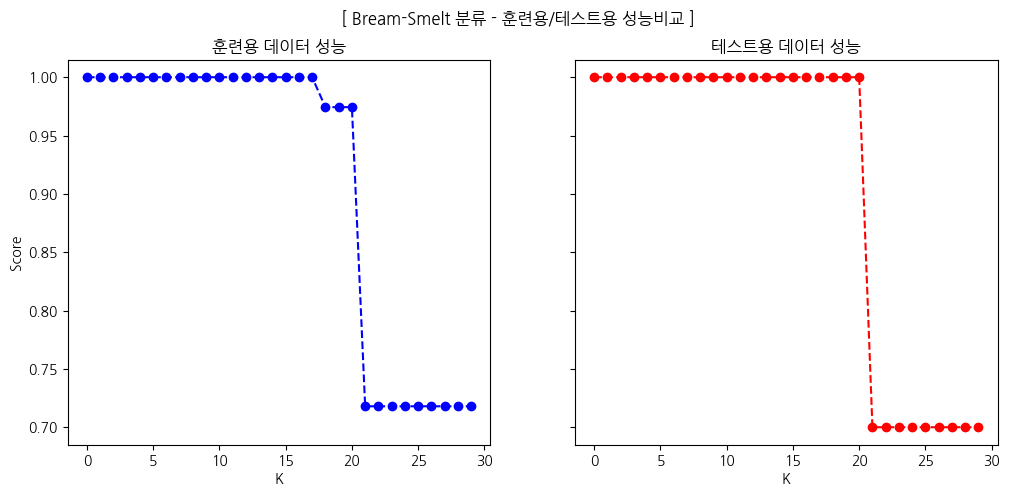

In [12]:
##- k 개수에 다른 학습 및 테스트 성능 시각화 
fig, axes = plt.subplots(1,2, sharey=True, figsize=(12, 5))

axes[0].plot(scoreDict['Train'], 'bo--')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Score')
axes[0].set_title("훈련용 데이터 성능")

axes[1].plot(scoreDict['Test'], 'ro--')
axes[1].set_xlabel('K')
axes[1].set_title("테스트용 데이터 성능")

plt.suptitle('[ Bream-Smelt 분류 - 훈련용/테스트용 성능비교 ]')
plt.show()


In [13]:
### ==============================================
### => 최적의 K = 3 : 홀수. 학습한 모델 인스턴스 생성
### ==============================================
kModel = KNeighborsClassifier(n_neighbors=3)
kModel.fit(x_train, y_train)

,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [14]:
sModel = KNeighborsClassifier(n_neighbors=3)
sModel.fit(scaled_x_train, y_train)

,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


[5] 성능평가 : 테스트용 데이터셋 <hr>
- 학습이 잘 되었는지 비교 평가
- 학습용 데이터셋 성능과 테스트용 데이터셋 성능 비교 
- 평가
    * Good :  학습용 점수와 테스트용 점수 비슷 또는 테스트용 점수가 높음
    * bad :  학습용 점수와 테스트용 점수 낮은 경우 / 테스트용 점수만 낮은 경우 

In [15]:
## 학습용/테스트용 점수 계산
train_score = kModel.score(x_train, y_train) 
test_score  = kModel.score(x_test, y_test) 

strain_score = sModel.score(scaled_x_train, y_train) 
stest_score  = sModel.score(scaled_x_test, y_test) 

print(f'[Train]  {train_score},  [Test] {test_score}')
print(f'[sTrain] {strain_score}, [sTest] {stest_score}')


[Train]  1.0,  [Test] 1.0
[sTrain] 1.0, [sTest] 1.0


[6] 예측 : 학습용/테스트용 아닌 일반 데이터들 <hr>

- 입력 데이터에 대한 예측 결과를 반환
- 예) 무게, 길이 입력 => bream, smelt 반환

In [16]:
## 예측 진행 
in_data  = [150, 25]  #[6.7, 9.8]  
new_data = pd.DataFrame([in_data] , columns=fishDF.columns[1:])
kModel.predict(new_data).item()   ## ndarray에서 원소 1개 있는 경우 item() 원소 추출 

'Smelt'

In [17]:
## 학습용 스케일러로 스케일링해서 예측
scaled_new_data = stdScaler.transform(new_data)

sModel.predict(scaled_new_data).item()

'Bream'

In [18]:
## 예측 검사 => k개 이웃 데이터 확인 
_, indices  = kModel.kneighbors(new_data)
_, sindices = sModel.kneighbors(scaled_new_data)


[07] 242.0 25.4
[04] 19.7 14.3
[05] 13.4 12.4


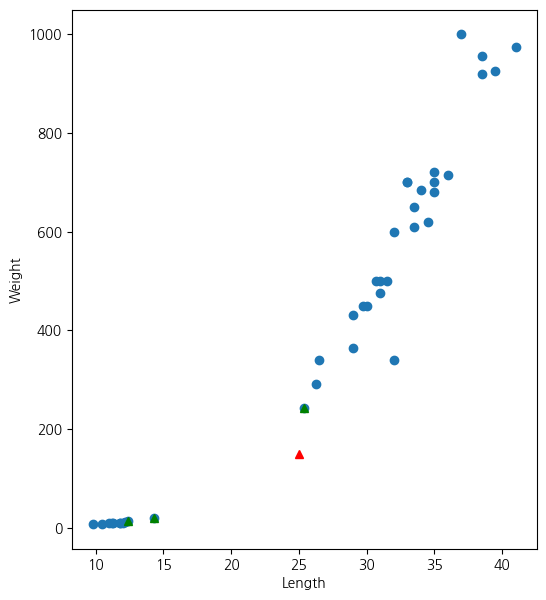

In [19]:
## 시각화 
plt.figure(figsize=(6, 7))

plt.scatter(x_train.Length, x_train.Weight)

#-> 새로운 데이터
plt.plot(new_data.Length, new_data.Weight, '^r')
#-> 이웃 데이터
nIdx = indices[0].tolist()
for idx in nIdx:
    print(f'[{idx:0>2}]', x_train.iloc[idx].Weight, x_train.iloc[idx].Length)
    plt.plot(x_train.iloc[idx].Length,x_train.iloc[idx].Weight, '^g')

plt.xlabel('Length')
plt.ylabel('Weight')
plt.show()


In [20]:
## ndarray에서 컬럼     추출 => [모든행, 컬럼인덱스] => [:, 0 ]
weight_col = scaled_x_train[:, 0]

## ndarray에서 행   1개 추출 => [행인덱스]
scaled_x_train[0]

## ndarray에서 행 여러개 추출 => [시작:끝+1]
scaled_x_train[0: 4]

array([[ 0.49638249,  0.50310895],
       [-1.33243816, -1.57164548],
       [ 0.18657042,  0.37467177],
       [ 0.86815697,  0.79950244]])

In [21]:
scaled_new_data[0][0], scaled_new_data[0][1]

(np.float64(-0.8977718239394702), np.float64(-0.1884758599093422))

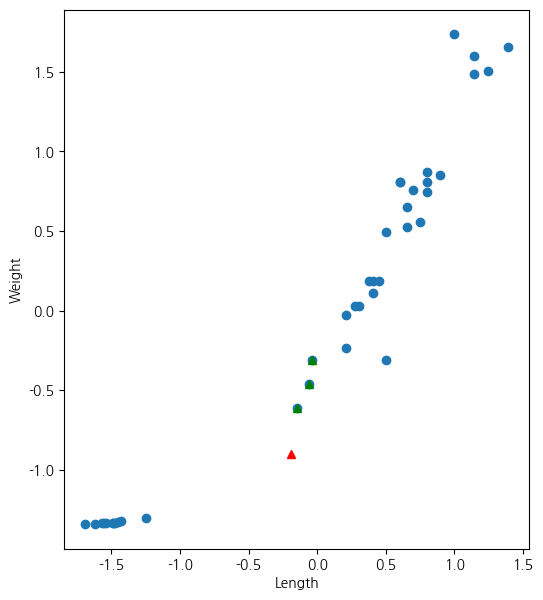

In [22]:
## 시각화 
plt.figure(figsize=(6, 7))

plt.scatter(scaled_x_train[:, 1], scaled_x_train[:, 0])

#-> 새로운 데이터
plt.plot(scaled_new_data[0][1], scaled_new_data[0][0], '^r')

# #-> 이웃 데이터
nIdx = sindices[0].tolist()
for idx in nIdx:
    plt.plot(scaled_x_train[idx][1], scaled_x_train[idx][0], '^g')

plt.xlabel('Length')
plt.ylabel('Weight')
plt.show()